In [1]:
%matplotlib notebook

import glob
import argparse
import numpy as np

from scipy.interpolate    import interp1d
from scipy.interpolate    import interp2d
from scipy                import integrate
from scipy                import signal
from scipy                import stats
from astropy.io           import fits

from photutils import detect_sources
from photutils import CircularAperture
from photutils import aperture_photometry
from matplotlib.ticker import AutoMinorLocator

import matplotlib.pylab as plt

In [2]:
# detectors' pixel size
HST_WFC3CAM_pixel_size = 0.13   # arcsec per pixel

# Constants 0
cm_in_pc = 3.0857e18
sun_luminosity = 3.828e33
arcsec_in_rad = 206265
c = 2.9927e10

In [3]:
'''
Interstellar medium transmission function
'''



table = np.loadtxt('data/table_transmition_ISM.dat')
lam_rest   = table[1:,0]
z          = table[0,1:]
trans_coef = table[1:,1:]
F_ISM = interp2d(z, lam_rest, trans_coef)



muf_list = sorted(glob.glob("data/drt/muv.bin*"))
print(muf_list)
lam_list = np.zeros(len(muf_list))
lookup = np.zeros([len(muf_list), 188, 22])

for i in range(len(muf_list)):
    f = open(muf_list[i])
    header = f.readline()
    lam_list[i] = float(header.split()[2])

    f.close()

    data = np.genfromtxt(muf_list[i], skip_header=1)
    lookup[i, :, :] = data[1:,1:]

Z = data[0, 1:]  # metallicity [Sun_Z]
logt = data[1:, 0]  # log10(t) [yr]

['data/drt/muv.bin=122.res', 'data/drt/muv.bin=123.res', 'data/drt/muv.bin=124.res', 'data/drt/muv.bin=125.res', 'data/drt/muv.bin=126.res', 'data/drt/muv.bin=127.res', 'data/drt/muv.bin=128.res', 'data/drt/muv.bin=129.res', 'data/drt/muv.bin=130.res', 'data/drt/muv.bin=131.res', 'data/drt/muv.bin=132.res', 'data/drt/muv.bin=133.res', 'data/drt/muv.bin=134.res', 'data/drt/muv.bin=135.res', 'data/drt/muv.bin=136.res', 'data/drt/muv.bin=137.res', 'data/drt/muv.bin=138.res', 'data/drt/muv.bin=139.res', 'data/drt/muv.bin=140.res', 'data/drt/muv.bin=141.res', 'data/drt/muv.bin=142.res', 'data/drt/muv.bin=143.res', 'data/drt/muv.bin=144.res', 'data/drt/muv.bin=145.res', 'data/drt/muv.bin=146.res', 'data/drt/muv.bin=147.res', 'data/drt/muv.bin=148.res', 'data/drt/muv.bin=149.res', 'data/drt/muv.bin=150.res', 'data/drt/muv.bin=151.res', 'data/drt/muv.bin=152.res', 'data/drt/muv.bin=153.res', 'data/drt/muv.bin=154.res', 'data/drt/muv.bin=155.res', 'data/drt/muv.bin=156.res', 'data/drt/muv.bin=1

In [18]:
def filter_bandwidth(a, b, x):

    position_in_lam_array = []

    for i in range(0,len(x)):
        if a <=x[i] and x[i] <= b:
            if F_filter(x[i])>=0.5e-3:
                position_in_lam_array.append(i)

    return position_in_lam_array

def plot_style(xticks=5,yticks=5):

    plt.rcParams.update({'figure.autolayout': True})
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['figure.figsize'] = 8, 7.5

    fig,ax = plt.subplots()
    x_minor_locator = AutoMinorLocator(xticks)
    y_minor_locator = AutoMinorLocator(yticks)
    plt.tick_params(which='both', width=1.7)
    plt.tick_params(which='major', length=9)
    plt.tick_params(which='minor', length=5)
    ax.xaxis.set_minor_locator(x_minor_locator)
    ax.yaxis.set_minor_locator(y_minor_locator)

def HST_filter_init(z, filter_name):

    '''
    Hubble Space Telescope filter initialization function
    '''

    global F_filter

    filter_b = np.loadtxt('data/filter_' + filter_name + '.dat')
    F_filter = interp1d(filter_b[:,0], filter_b[:,1],fill_value=0.0,bounds_error=False)
    a,b = np.min(filter_b[:,0]),np.max(filter_b[:,0])
    lamb_positions = filter_bandwidth(a,b,lam_list*(1+z))

    return lamb_positions

<IPython.core.display.Javascript object>


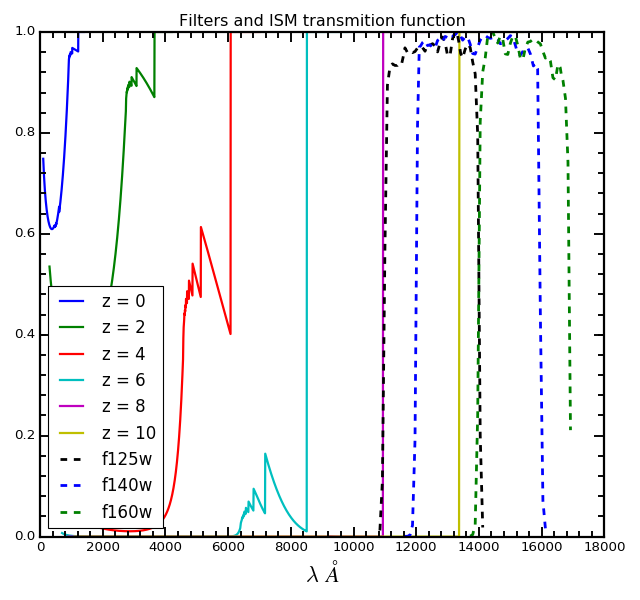

In [21]:
plot_style()
redshift = 7
for i in range(0,12,2):
    plt.plot(lam_rest*(i+1),F_ISM(i,lam_rest),label='z = ' + str(i),lw=2)
for filter_name in ['f125w','f140w','f160w']:
    lamb_positions = HST_filter_init(filter_name=filter_name,z=redshift)
    lamb_filter = lam_list[lamb_positions]
    plt.plot(lamb_filter*(1+redshift),F_filter(lamb_filter*(1+redshift)),'--',lw=2.5,label=filter_name)
    plt.xlabel('$\lambda$ $\AA$',fontsize=20)
    plt.legend(loc='lower left',fontsize=15)
    plt.title('Filters and ISM transmition function')
    plt.savefig('HST1.pdf',format='pdf')

    

In [22]:
redshift=6

# Cosmo params
Omega_lam = 0.7274
Omega_M_0 = 0.2726
Omega_k = 0.0
h = 0.704

# Functions to compute Angular diameter distance D_A [Mpc]
E   = lambda x: 1/np.sqrt(Omega_M_0*np.power(1+x,3)+Omega_lam+Omega_k*np.power(1+x,2))
D_m = lambda x: D_c(x)
D_c = lambda x: (9.26e27/h)*integrate.quad(E, 0, x)[0]
D_A = lambda x: D_m(x)/(1+x)/cm_in_pc/1e6  # Angular distance [Mpc]

# LUMINOSITY DISTANCE = ANGULAR DISTANCE (1+z)**2
lum_dist = D_A(redshift) * (1 + redshift) * (1 + redshift)

# INTERPOLATION
lookup_averaged = np.zeros((len(logt),len(Z),3))

for filter_name, filter_idx in zip(['f125w', 'f140w', 'f160w'],[0,1,2]):

    lamb_positions = HST_filter_init(filter_name=filter_name,z=redshift)
    lamb_filter = lam_list[lamb_positions]
    nu = c/(lamb_filter/1e8)

    for ii in range(len(Z)):
        for jj in range(len(logt)):
            lookup_averaged[jj,ii,filter_idx] = integrate.trapz( lookup[lamb_positions,jj, ii][::-1] * F_ISM(redshift,lamb_filter)[::-1,0] * \
                                                      F_filter(lamb_filter[::-1]*(1+redshift))/nu[::-1], nu[::-1]) * 1e23 * 1e9 * \
                                                      (1+redshift) / (4 * np.pi * np.power(lum_dist*cm_in_pc*1e6, 2)) * sun_luminosity / \
                                                      integrate.trapz( F_filter(lamb_filter[::-1]*(1+redshift))/nu[::-1], nu[::-1])
    print(filter_name, filter_idx)

interp125 = interp2d(Z, logt, lookup_averaged[:,:,0])
interp140 = interp2d(Z, logt, lookup_averaged[:,:,1])
interp160 = interp2d(Z, logt, lookup_averaged[:,:,2])

print('f125', np.mean(lookup_averaged[:,:,0]), np.max(lookup_averaged[:,:,0]))
print('f140', np.mean(lookup_averaged[:,:,1]), np.max(lookup_averaged[:,:,1]))
print('f160', np.mean(lookup_averaged[:,:,2]), np.max(lookup_averaged[:,:,2]))

f125w 0
f140w 1
f160w 2
f125 4.03292903807e-07 2.41795534249e-06
f140 3.78357902263e-07 2.35473721891e-06
f160 3.3859142751e-07 2.18887640743e-06


In [59]:
# NOISE
nbins=1000

'''
Procedure to create noise for specific filter and exposure time (only for JWST)
'''

global noise125, noise140, noise160, noise_std125, noise_std140, noise_std160

zero_point = np.array([26.23,26.45,25.94])
coeff = 10 ** (0.4 * (zero_point + 48.6))

coeff_125 = 1e23 * 1e9 / coeff[0]
coeff_140 = 1e23 * 1e9 / coeff[1]
coeff_160 = 1e23 * 1e9 / coeff[2]

noise = np.vstack((stats.norm.rvs(0.0,0.00275845*coeff_125,nbins*nbins),
                   stats.norm.rvs(0.0,3.26572605e-03*coeff_140,nbins*nbins),
                   stats.norm.rvs(0.0,0.00239519*coeff_160,nbins*nbins)))

noise_std125 = np.std(noise[0,:])
noise125 = np.reshape(noise[0,:],(nbins,nbins))
noise_std140 = np.std(noise[1,:])
noise140 = np.reshape(noise[1,:],(nbins,nbins))
noise_std160 = np.std(noise[2,:])
noise160 = np.reshape(noise[2,:],(nbins,nbins))

print(noise_std125, 'nJy')
print(noise_std140, 'nJy')
print(noise_std160, 'nJy')

0.32236051127 nJy
0.312144816405 nJy
0.365450524896 nJy


<IPython.core.display.Javascript object>


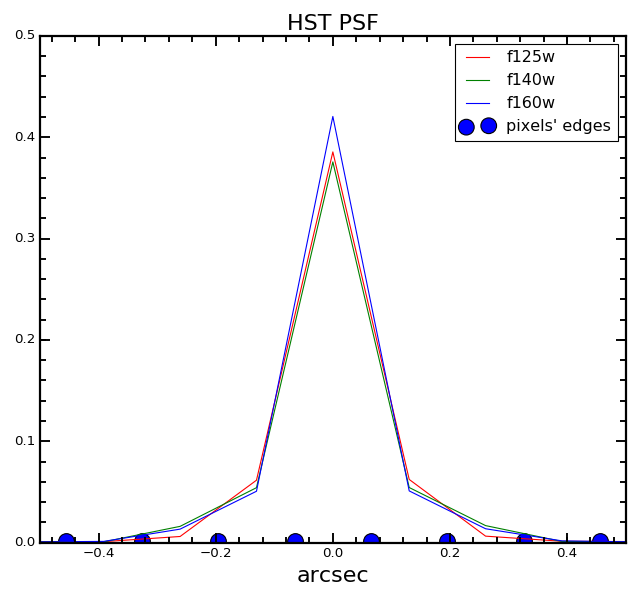

0.998186023455
0.999006222056
0.998895542134


In [24]:
# PSF
plot_style()
a = fits.open('data/psf_test_f125w00_psf.fits')[0].data[1:,1:]
b = fits.open('data/psf_test_f140w00_psf.fits')[0].data[1:,1:]
c = fits.open('data/psf_test_f160w00_psf.fits')[0].data[1:,1:]

coords_a = np.linspace(-1.5 + 1.5/np.shape(a)[0],1.5 - 1.5/np.shape(a)[0],np.shape(a)[0])
coords_b = np.linspace(-1.5 + 1.5/np.shape(b)[0],1.5 - 1.5/np.shape(b)[0],np.shape(b)[0])
coords_c = np.linspace(-1.5 + 1.5/np.shape(c)[0],1.5 - 1.5/np.shape(c)[0],np.shape(c)[0])

NNbins = int(3/HST_WFC3CAM_pixel_size)
pix_edges = np.linspace(-1.5,1.5,NNbins+1)

x, y = np.meshgrid(coords_a, coords_a)
psf_f125w,X,Y = np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = a.flatten())
x, y = np.meshgrid(coords_b, coords_b)
psf_f140w,X,Y = np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = b.flatten())
x, y = np.meshgrid(coords_c, coords_c)
psf_f160w,X,Y = np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = c.flatten())

PSF125 = psf_f125w
PSF140 = psf_f140w
PSF160 = psf_f160w

bins = (pix_edges[:-1] + pix_edges[1:])/2
plt.plot(bins, PSF125[11,:],'r',label='f125w')
plt.plot(bins, PSF140[11,:],'g',label='f140w')
plt.plot(bins, PSF160[11,:],'b',label='f160w')
plt.scatter(pix_edges,np.ones(len(pix_edges))/5e2,s=200,label='pixels\' edges')
plt.ylim(0,0.5)
plt.xlim(-0.5,0.5)
plt.xlabel('arcsec',fontsize=20)
plt.title('HST PSF',fontsize=20)
plt.legend(scatterpoints=2)
plt.savefig('HSTPSF.pdf',format='pdf')

print(np.sum(PSF125))
print(np.sum(PSF140))
print(np.sum(PSF160))